In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import torch
import torch.utils.data
from lib.opts import opts
from lib.models.model import create_model, load_model, save_model
from lib.models.data_parallel import DataParallel
from lib.logger import Logger
from lib.datasets.dataset_factory import collate_fn_filtered
from lib.trains.train_factory import train_factory
import time
import numpy as np

from lib.datasets.dataset_combined import ObjectPoseDataset

2024-10-23 02:38:59.797084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 02:38:59.808803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 02:38:59.812409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 02:38:59.823229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 02:39:00.596348: W tensorflow/compiler/tf2

2.4.1+cu121


In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.multiprocessing.set_start_method('spawn')


In [4]:
import sys
sys.argv = [
    "program_name",
    "--load_model", 
    "/home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-18-06-50/custom_box_best.pth",
    "--resume"
]

In [5]:

# Default params with commandline input
opt = opts()
opt = opt.parser.parse_args()

# Local configuration
opt.c = 'custom_box'
opt.arch='dlav1_34'
opt.obj_scale = True
opt.obj_scale_weight = 1
opt.mug = False

# Training param
opt.exp_id = f'objectron_{opt.c}_{opt.arch}'
opt.num_epochs = 140
opt.val_intervals = 5
opt.lr_step = '90,120'
opt.batch_size = 16
opt.lr = 6e-5
opt.gpus = '0'
opt.num_workers = 4
opt.print_iter = 5
opt.debug = 5
opt.save_all = True

# # To continue
# opt.resume = True
# opt.load_model = ""

# Copy from parse function from opts.py
opt.gpus_str = opt.gpus
opt.gpus = [int(gpu) for gpu in opt.gpus.split(',')]
opt.gpus = [i for i in range(len(opt.gpus))] if opt.gpus[0] >= 0 else [-1]
opt.lr_step = [int(i) for i in opt.lr_step.split(',')]
opt.test_scales = [float(i) for i in opt.test_scales.split(',')]

opt.fix_res = not opt.keep_res
print('Fix size testing.' if opt.fix_res else 'Keep resolution testing.')
opt.reg_offset = not opt.not_reg_offset
opt.reg_bbox = not opt.not_reg_bbox
opt.hm_hp = not opt.not_hm_hp
opt.reg_hp_offset = (not opt.not_reg_hp_offset) and opt.hm_hp

if opt.head_conv == -1:  # init default head_conv
    opt.head_conv = 256 if 'dla' in opt.arch else 64
opt.pad = 127 if 'hourglass' in opt.arch else 31
opt.num_stacks = 2 if opt.arch == 'hourglass' else 1

if opt.trainval:
    opt.val_intervals = 100000000

if opt.master_batch_size == -1:
    opt.master_batch_size = opt.batch_size // len(opt.gpus)
rest_batch_size = (opt.batch_size - opt.master_batch_size)
opt.chunk_sizes = [opt.master_batch_size]
for i in range(len(opt.gpus) - 1):
    slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
    if i < rest_batch_size % (len(opt.gpus) - 1):
        slave_chunk_size += 1
    opt.chunk_sizes.append(slave_chunk_size)
print('training chunk_sizes:', opt.chunk_sizes)

# opt.root_dir = os.path.join(os.path.dirname(__file__), '..') # CenterPose/
opt.root_dir = "/home/CenterPose/"
opt.data_dir = os.path.join(opt.root_dir, 'data') # CenterPose/data
opt.exp_dir = os.path.join(opt.root_dir, 'exp', opt.task) # CenterPose/exp/opt.task

time_str = time.strftime('%Y-%m-%d-%H-%M')
opt.save_dir = os.path.join(opt.exp_dir, f'{opt.exp_id}_{time_str}')
opt.debug_dir = os.path.join(opt.save_dir, 'debug')
print('The output will be saved to ', opt.save_dir)

# custom options
opt.custom = True
opt.num_workers = 0
opt.obj_scale_weight = 0
if opt.c == 'custom_box':
    opt.data_dir = '/home/CenterPose/data/custom_box'

Fix size testing.
training chunk_sizes: [16]
The output will be saved to  /home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-23-02-39


In [6]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

Dataset = ObjectPoseDataset


opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

logger = Logger(opt)

os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

print('Creating model...')
model = create_model(opt.arch, opt.heads, opt.head_conv, opt=opt)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(
        model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

print('Setting up data...')
val_dataset = Dataset(opt, 'val')
if opt.tracking_task == True:
    val_dataset_subset = torch.utils.data.Subset(val_dataset, range(0, len(val_dataset), 15))
else:
    val_dataset_subset = val_dataset

val_loader = torch.utils.data.DataLoader(
    val_dataset_subset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn_filtered
)

if opt.test:
    _, preds, _ = trainer.val(0, val_loader)

# print("train datset test")
# example_train = Dataset(opt, 'train')
# # print(example_train[0])
# for i in range(len(example_train)):
#     try:
#         item = example_train[i]
#         if item is None:
#             print(f"Item {i} is None")
#     except Exception as e:
#         print(f"Error loading item {i}: {e}")

train_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'train'),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn_filtered
)

heads {'hm': 1, 'wh': 2, 'hps': 16, 'reg': 2, 'hm_hp': 8, 'hp_offset': 2, 'scale': 3}
Creating model...


loaded /home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-18-06-50/custom_box_best.pth, epoch 95
No optimizer parameters in checkpoint.
Setting up data...
self.img_dir:  /home/CenterPose/data/custom_box/custom_box_test
Loaded test 30 samples
Creating video index!
self.img_dir:  /home/CenterPose/data/custom_box/custom_box_train
Loaded train 245 samples
Creating video index!


Starting training...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6909887..2.0513685].


샘플 배치의 키:
- input
- hm
- reg_mask
- ind
- hps
- hps_mask
- scale
- wh
- reg
- hm_hp
- hp_offset
- hp_ind
- hp_mask
- meta

입력 이미지 크기: torch.Size([1, 3, 512, 512])
메타 정보: dict_keys(['c', 's', 'gt_det', 'img_id'])


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

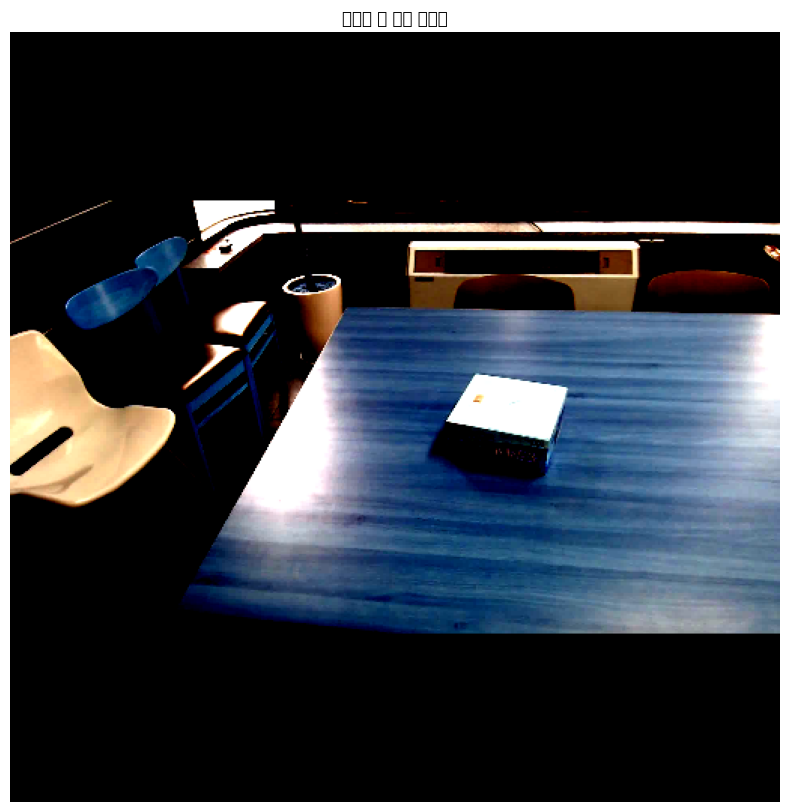

In [7]:
print('Starting training...')
best = 1e10

# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
epoch = 1
mark = epoch if opt.save_all else 'last'

# log_dict_train, _, log_imgs = trainer.train(epoch, train_loader)

model_with_loss = trainer.model_with_loss
phase = 'val'
model_with_loss.eval()

opt = trainer.opt
results = {}
writer_imgs = []  # Clear before each epoch # For tensorboard

# train_loader에서 하나의 배치 꺼내기
data_iter = iter(val_loader)
sample_batch = next(data_iter)

print('샘플 배치의 키:')
for key in sample_batch:
    print(f'- {key}')

print('\n입력 이미지 크기:', sample_batch['input'].shape)
print('메타 정보:', sample_batch['meta'].keys())

# 배치에서 첫 번째 이미지 시각화 (선택사항)
if 'input' in sample_batch:
    first_image = sample_batch['input'][0].permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(first_image)
    plt.title('배치의 첫 번째 이미지')
    plt.axis('off')
    plt.show()

In [8]:
from lib.models.decode import object_pose_decode

for k in sample_batch:
    if k != 'meta':
        sample_batch[k] = sample_batch[k].to(device=opt.device, non_blocking=True)

output_trainer, loss, loss_stats, choice_list = model_with_loss(sample_batch, 'train')

hps_uncertainty = output_trainer['hps_uncertainty'] if opt.hps_uncertainty else None
reg = output_trainer['reg'] if opt.reg_offset else None
hm_hp = output_trainer['hm_hp'] if opt.hm_hp else None
hp_offset = output_trainer['hp_offset'] if opt.reg_hp_offset else None
obj_scale = output_trainer['scale'] if opt.obj_scale else None
obj_scale_uncertainty = output_trainer['scale_uncertainty'] if opt.obj_scale_uncertainty else None
wh = output_trainer['wh'] if opt.reg_bbox else None
tracking = output_trainer['tracking'] if 'tracking' in opt.heads else None
tracking_hp = output_trainer['tracking_hp'] if 'tracking_hp' in opt.heads else None

dets_trainer = object_pose_decode(
    output_trainer['hm'], output_trainer['hps'], wh=wh, kps_displacement_std=hps_uncertainty, obj_scale=obj_scale,
    obj_scale_uncertainty=obj_scale_uncertainty,
    reg=reg, hm_hp=hm_hp, hp_offset=hp_offset, tracking=tracking, tracking_hp=tracking_hp, opt=opt)

        


### demo_custom.py

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import cv2

from lib.opts import opts
from lib.detectors.detector_factory import detector_factory
from lib.detectors.my_detector import MyDetector

import glob
import numpy as np

import torch

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge', 'pnp', 'track']


In [10]:
sys.argv = [
    "program_name",
    "--load_model", "/home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-18-06-50/custom_box_best.pth",
    "--demo", "/home/custom_dataset/box_folders/box_tea_1/_output"
]

In [11]:
opt = opts().parser.parse_args()

# Local machine configuration example for CenterPose
# opt.c = 'cup' # Only meaningful when enables show_axes option
# opt.demo = "../images/CenterPose/cup/00007.png"
# opt.arch = 'dlav1_34'
# opt.load_model = f"../models/CenterPose/cup_mug_v1_140.pth"
# opt.debug = 2
# opt.show_axes = True

# Local machine configuration example for CenterPoseTrack
# opt.c = 'cup' # Only meaningful when enables show_axes option
# opt.demo = '../images/CenterPoseTrack/shoe_batch-25_10.mp4'
# opt.tracking_task = True
# opt.arch = 'dla_34'
# opt.load_model = f"../models/CenterPoseTrack/shoe_15.pth"
# opt.debug = 2
# opt.show_axes = True

# Default setting
opt.nms = True
opt.obj_scale = True

# Tracking stuff
if opt.tracking_task == True:
    print('Running tracking')
    opt.pre_img = True
    opt.pre_hm = True
    opt.tracking = True
    opt.pre_hm_hp = True
    opt.tracking_hp = True
    opt.track_thresh = 0.1

    opt.obj_scale_uncertainty = True
    opt.hps_uncertainty = True
    opt.kalman = True
    opt.scale_pool = True

    opt.vis_thresh = max(opt.track_thresh, opt.vis_thresh)
    opt.pre_thresh = max(opt.track_thresh, opt.pre_thresh)
    opt.new_thresh = max(opt.track_thresh, opt.new_thresh)

    # # For tracking moving objects, better to set up a small threshold
    # opt.max_age = 2

    print('Using tracking threshold for out threshold!', opt.track_thresh)

# PnP related
meta = {}
if opt.cam_intrinsic is None:
    meta['camera_matrix'] = np.array(
        [[663.0287679036459, 0, 300.2775065104167], [0, 663.0287679036459, 395.00066121419275], [0, 0, 1]])
    opt.cam_intrinsic = meta['camera_matrix']
else:
    meta['camera_matrix'] = np.array(opt.cam_intrinsic).reshape(3, 3)

# Update default configurations
opt = opts().parse(opt)

# Update dataset info/training params
opt = opts().init(opt)

opt.c = 'custom_box'
opt.arch = 'dlav1_34'


Fix size testing.
training chunk_sizes: [1]
The output will be saved to  /home/CenterPose/src/lib/../../exp/object_pose/default
heads {'hm': 1, 'wh': 2, 'hps': 16, 'reg': 2, 'hm_hp': 8, 'hp_offset': 2, 'scale': 3}


In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
# Detector = detector_factory[opt.task]
detector = MyDetector(opt)

if opt.use_pnp == True and 'camera_matrix' not in meta.keys():
    raise RuntimeError('Error found. Please give the camera matrix when using pnp algorithm!')

if opt.demo == 'webcam' or \
        opt.demo[opt.demo.rfind('.') + 1:].lower() in video_ext:
    cam = cv2.VideoCapture(0 if opt.demo == 'webcam' else opt.demo)
    detector.pause = False

    # Check if camera opened successfully
    if (cam.isOpened() == False):
        print("Error opening video stream or file")

    idx = 0
    while (cam.isOpened()):
        _, img = cam.read()
        try:
            cv2.imshow('input', img)
        except:
            exit(1)

        filename = os.path.splitext(os.path.basename(opt.demo))[0] + '_' + str(idx).zfill(
            4) + '.png'
        ret = detector.run(img, meta_inp=meta,
                            filename=filename)
        idx = idx + 1

        time_str = ''
        for stat in time_stats:
            time_str = time_str + '{} {:.3f}s |'.format(stat, ret[stat])
        print(f'Frame {str(idx).zfill(4)}|' + time_str)
        if cv2.waitKey(1) == 27:
            break
else:

    # # Option 1: only for XX_test with a lot of sub-folders
    # image_names = []
    # for ext in image_ext:
    #     file_name=glob.glob(os.path.join(opt.demo,f'**/*.{ext}'))
    #     if file_name is not []:
    #         image_names+=file_name

    # Option 2: if we have images just under a folder, uncomment this instead
    if os.path.isdir(opt.demo):
        image_names = []
        ls = os.listdir(opt.demo)
        for file_name in sorted(ls):
            ext = file_name[file_name.rfind('.') + 1:].lower()
            if ext in image_ext:
                image_names.append(os.path.join(opt.demo, file_name))
    else:
        image_names = [opt.demo]

    detector.pause = False
    print("현재 작업 디렉토리:", os.getcwd())
    for idx, image_name in enumerate(image_names):
        if "0005" in image_name: break
    print(image_name)    

Creating model...
loaded /home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-18-06-50/custom_box_best.pth, epoch 95
현재 작업 디렉토리: /home/CenterPose/src
/home/custom_dataset/box_folders/box_tea_1/_output/0005.jpg


In [13]:
from lib.utils.debugger import Debugger
# img_dict = detector.run(image_name, meta_inp=meta)

image_or_path_or_tensor = image_name
meta_inp = {}

load_time, pre_time, net_time, dec_time, post_time = 0, 0, 0, 0, 0
merge_time, track_time, pnp_time, tot_time = 0, 0, 0, 0
debugger = Debugger(dataset=detector.opt.dataset, ipynb=(detector.opt.debug == 3),
                    theme=detector.opt.debugger_theme)
start_time = time.time()

# pre_processed = preprocessed_flag
pre_processed = False

# File input
if isinstance(image_or_path_or_tensor, np.ndarray):
    # For eval or for CenterPose as data generator
    image = image_or_path_or_tensor

    # We usually use image_or_path_or_tensor to represent filename
    if filename is not None:
        image_or_path_or_tensor = filename

# String input
elif type(image_or_path_or_tensor) == type(''):
    # For demo
    image = cv2.imread(image_or_path_or_tensor)
else:
    # Not used yet
    image = image_or_path_or_tensor['image'][0].numpy()
    pre_processed_images = image_or_path_or_tensor
    pre_processed = True

loaded_time = time.time()
load_time += (loaded_time - start_time)

detections = []

# self.scales : [1.0]
for scale in detector.scales:
    scale_start_time = time.time()
    if not pre_processed:
        images, meta = detector.pre_process(image, scale, meta_inp)
    else:

        # Used for data generation
        # 1 * 3 * 512 * 512
        images = np.expand_dims(image, axis=0)
        # images = image.reshape(1, 3, meta_inp['inp_height'], meta_inp['inp_width'])
        images = torch.from_numpy(images)
        meta = meta_inp

    images = images.to(detector.opt.device)
    # initializing tracker
    pre_hms, pre_hm_hp, pre_inds = None, None, None

    torch.cuda.synchronize()
    pre_process_time = time.time()
    pre_time += pre_process_time - scale_start_time

    # run the network
    # output: the output feature maps, only used for visualizing
    # dets: output tensors after extracting peaks
    output_demo, dets_demo, forward_time = detector.process(
        images, detector.pre_images, pre_hms, pre_hm_hp, pre_inds, return_time=True)

output_demo와 output_trainer 비교:
공통 키: {'hm', 'scale', 'reg', 'hp_offset', 'hps', 'hm_hp', 'wh'}
demo에만 있는 키: {'pre_inds'}
trainer에만 있는 키: set()

hm 비교:
형태: demo torch.Size([1, 1, 128, 128]), trainer torch.Size([1, 1, 128, 128])
최대 차이: 0.001859426498413086
평균 차이: 7.837361408746801e-06

scale 비교:
형태: demo torch.Size([1, 3, 128, 128]), trainer torch.Size([1, 3, 128, 128])
최대 차이: 0.011554338037967682
평균 차이: 0.0007933552260510623

reg 비교:
형태: demo torch.Size([1, 2, 128, 128]), trainer torch.Size([1, 2, 128, 128])
최대 차이: 0.005500376224517822
평균 차이: 0.00045184424379840493

hp_offset 비교:
형태: demo torch.Size([1, 2, 128, 128]), trainer torch.Size([1, 2, 128, 128])
최대 차이: 0.0008931197226047516
평균 차이: 0.00011577169789234176

hps 비교:
형태: demo torch.Size([1, 16, 128, 128]), trainer torch.Size([1, 16, 128, 128])
최대 차이: 0.05923938751220703
평균 차이: 0.0027110008522868156

hm_hp 비교:
형태: demo torch.Size([1, 8, 128, 128]), trainer torch.Size([1, 8, 128, 128])
최대 차이: 0.002434968948364258
평균 차이: 1.16626015369

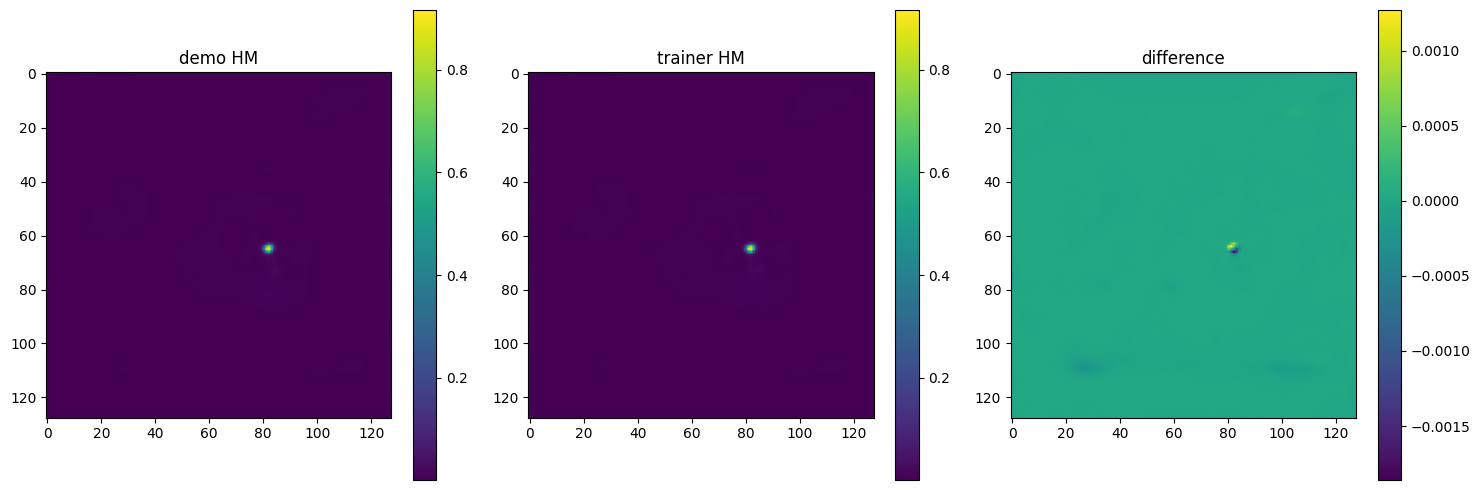

비교 완료


In [14]:
# output_demo와 output_trainer 비교

print("output_demo와 output_trainer 비교:")

# output_demo와 output_trainer의 키 비교
demo_keys = set(output_demo.keys())
trainer_keys = set(output_trainer.keys())

print("공통 키:", demo_keys.intersection(trainer_keys))
print("demo에만 있는 키:", demo_keys - trainer_keys)
print("trainer에만 있는 키:", trainer_keys - demo_keys)

# 공통 키에 대한 텐서 형태 및 값 비교
for key in demo_keys.intersection(trainer_keys):
    print(f"\n{key} 비교:")
    demo_tensor = output_demo[key]
    trainer_tensor = output_trainer[key]
    
    print(f"형태: demo {demo_tensor.shape}, trainer {trainer_tensor.shape}")
    
    if demo_tensor.shape == trainer_tensor.shape:
        diff = torch.abs(demo_tensor - trainer_tensor)
        print(f"최대 차이: {diff.max().item()}")
        print(f"평균 차이: {diff.mean().item()}")
    else:
        print("형태가 다르므로 직접적인 비교 불가")

# 시각화를 위해 첫 번째 배치의 'hm' 비교 (있다고 가정)
if 'hm' in demo_keys and 'hm' in trainer_keys:
    plt.figure(figsize=(15, 5))
    
    # 두 플롯의 값 범위를 계산합니다
    demo_hm = output_demo['hm'][0].sum(dim=0).cpu().detach().numpy()
    trainer_hm = output_trainer['hm'][0].sum(dim=0).cpu().detach().numpy()
    vmin = min(demo_hm.min(), trainer_hm.min())
    vmax = max(demo_hm.max(), trainer_hm.max())

    plt.subplot(131)
    plt.title("demo HM")
    plt.imshow(demo_hm, vmin=vmin, vmax=vmax)
    plt.colorbar()
    
    plt.subplot(132)
    plt.title("trainer HM")
    plt.imshow(trainer_hm, vmin=vmin, vmax=vmax)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("difference")
    diff = output_demo['hm'][0].sum(dim=0) - output_trainer['hm'][0].sum(dim=0)
    plt.imshow(diff.cpu().detach().numpy())
    
    plt.colorbar()
    plt.tight_layout()
    plt.show()

print("비교 완료")


In [15]:
std_tensor = torch.tensor(opt.std, device=images.device).view(1, 3, 1, 1)
mean_tensor = torch.tensor(opt.mean, device=images.device).view(1, 3, 1, 1)

# PyTorch 텐서로 계산 수행
img = ((images * std_tensor + mean_tensor) * 255).clamp(0, 255).byte()

# CPU로 이동 후 NumPy 배열로 변환
img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
# print(f'dets: {dets}')

# return
# print(f'output["hm"]: {output["hm"].shape}')
i=0
pred_demo = debugger.gen_colormap(output_demo['hm'][i].detach().cpu().numpy())
pred_trainer = debugger.gen_colormap(output_trainer['hm'][i].detach().cpu().numpy())
# gt = debugger.gen_colormap(batch['hm'][i][choice_list[i]].detach().cpu().numpy())
debugger.add_blend_img(img, pred_demo, 'demo_hm_pred')
debugger.add_blend_img(img, pred_trainer, 'trainer_hm_pred')
# debugger.add_blend_img(img, gt, 'out_hm_gt')

# Predictions
debugger.add_img(img, img_id='demo_img_pred')
debugger.add_img(img, img_id='trainer_img_pred')
# print(f"dets['scores'][i]: {len(dets['scores'][i])}")
for k in range(len(dets['scores'][i])):
    # print(f"score: {dets['scores'][i][k][0]}/{opt.center_thresh}")
    if dets['scores'][i][k][0] > opt.center_thresh:
        if opt.reg_bbox:
            debugger.add_coco_bbox(dets['bboxes'][i][k], dets['clses'][i][k],
                                    dets['scores'][i][k][0], img_id='out_img_pred')
        debugger.add_coco_hp(dets['kps'][i][k], img_id='out_img_pred')

if opt.hm_hp:
    # print(f'output["hm_hp"]: {output["hm_hp"].shape}') # [1 * 8 * 128 * 128]
    pred = debugger.gen_colormap_hp(output_demo['hm_hp'][i].detach().cpu().numpy())
    debugger.add_blend_img(img, pred, 'out_hmhp_pred')

plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(debugger.imgs.items()):
    plt.subplot(1, len(debugger.imgs), i+1)
    plt.title(key)
    plt.imshow(value)
plt.show()


NameError: name 'dets' is not defined

In [ ]:
# print(f'img_dict: {img_dict}')
# for key, value in img_dict.items():
#     (cv2.imwrite('demo_output/'+f'{image_name.split("/")[-1].split(".")[0]}_{key}.png', value))
# debugger(ret)